# NFL Quarterback Exploratory Data Analysis (EDA)

This notebook performs exploratory data analysis on the cleaned NFL QB tables to inform feature engineering and modeling.

## 1. Import Required Libraries

Import the core libraries for data analysis and visualization.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Set visualization style
sns.set(style="whitegrid")

In [2]:
# Connect to the database and load qb_statistics (data_load path)
db_path = 'data_load/nfl_qb_data.db'
conn = sqlite3.connect(db_path)

# Load the main QB statistics table
df = pd.read_sql('SELECT * FROM qb_statistics', conn)

print(f"Loaded {len(df)} rows from qb_statistics")
print(f"Columns: {df.columns.tolist()}")
df.head()

Loaded 10029 rows from qb_statistics
Columns: ['player_id', 'player_name', 'position', 'position_group', 'headshot_url', 'season', 'week', 'season_type', 'team', 'opponent_team', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'passing_interceptions', 'sacks_suffered', 'sack_yards_lost', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'passing_cpoe', 'passing_2pt_conversions', 'pacr', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions']


,player_id,player_name,position,position_group,headshot_url,season,week,season_type,team,opponent_team,...,passing_2pt_conversions,pacr,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_epa,rushing_2pt_conversions
0,00-0004161,Jake Delhomme,QB,QB,https://static.www.nfl.com/image/private/f_aut...,2010,1,REG,CLE,TB,...,0,0.625344,1,1,0,0,0,0,-1.174043,0
1,00-0005106,Brett Favre,QB,QB,https://static.www.nfl.com/image/private/f_aut...,2010,1,REG,MIN,NO,...,0,0.610714,0,0,0,0,0,0,NaN,0
2,00-0007091,Matt Hasselbeck,QB,QB,https://static.www.nfl.com/image/private/f_aut...,2010,1,REG,SEA,SF,...,0,1.287879,2,4,1,0,0,1,0.632133,0
3,00-0010346,Peyton Manning,QB,QB,https://static.www.nfl.com/image/private/f_aut...,2010,1,REG,IND,HOU,...,0,0.953744,0,0,0,0,0,0,NaN,0
4,00-0011022,Donovan McNabb,QB,QB,https://static.www.nfl.com/image/private/f_aut...,2010,1,REG,WAS,DAL,...,0,0.660232,1,17,0,0,0,1,2.184220,0


## 3. Data Overview & Summary Statistics

Get a sense of the data: shape, columns, types, missing values, and basic statistics.

In [3]:
# Data shape and columns
df.shape, df.columns.tolist()

# Data types
df.dtypes

# Missing values
df.isnull().sum()

# Basic statistics
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
player_id,10029,267,00-0023459,239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
player_name,10029,267,Aaron Rodgers,239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
position,10029,1,QB,10029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
position_group,10029,1,QB,10029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
headshot_url,10029,268,https://static.www.nfl.com/image/upload/f_auto...,239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,10029.0,NaN,NaN,NaN,2017.4827,4.555865,2010.0,2014.0,2018.0,2021.0,2025.0
week,10029.0,NaN,NaN,NaN,9.54472,5.343927,1.0,5.0,10.0,14.0,22.0
season_type,10029,2,REG,9641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
team,10029,32,CAR,343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
opponent_team,10029,32,SF,329,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Target Variable Distribution

Visualize and analyze the distribution of the main target variable(s) (e.g., QBR, EPA, or custom rating).

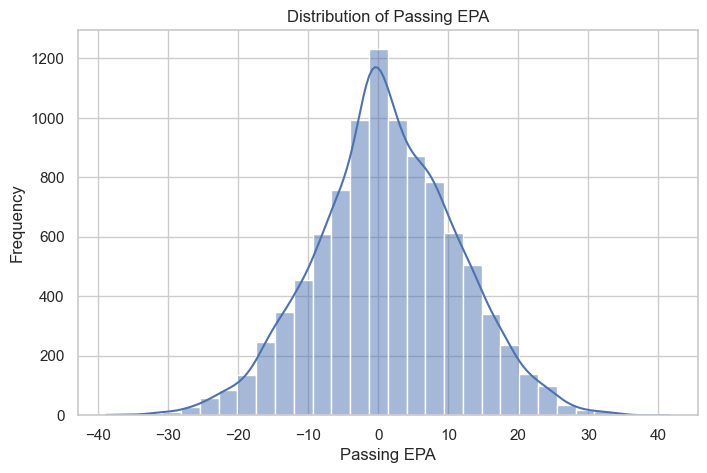

In [4]:
# Visualize passing EPA distribution (key performance metric)
plt.figure(figsize=(8, 5))
sns.histplot(df['passing_epa'].dropna(), bins=30, kde=True)
plt.title('Distribution of Passing EPA')
plt.xlabel('Passing EPA')
plt.ylabel('Frequency')
plt.show()

Shows us there is a normal distribution for EPA

## 5. Feature Distributions & Relationships

Explore key features: distributions, correlations, and pairwise relationships. Visualize with histograms, boxplots, and pairplots.

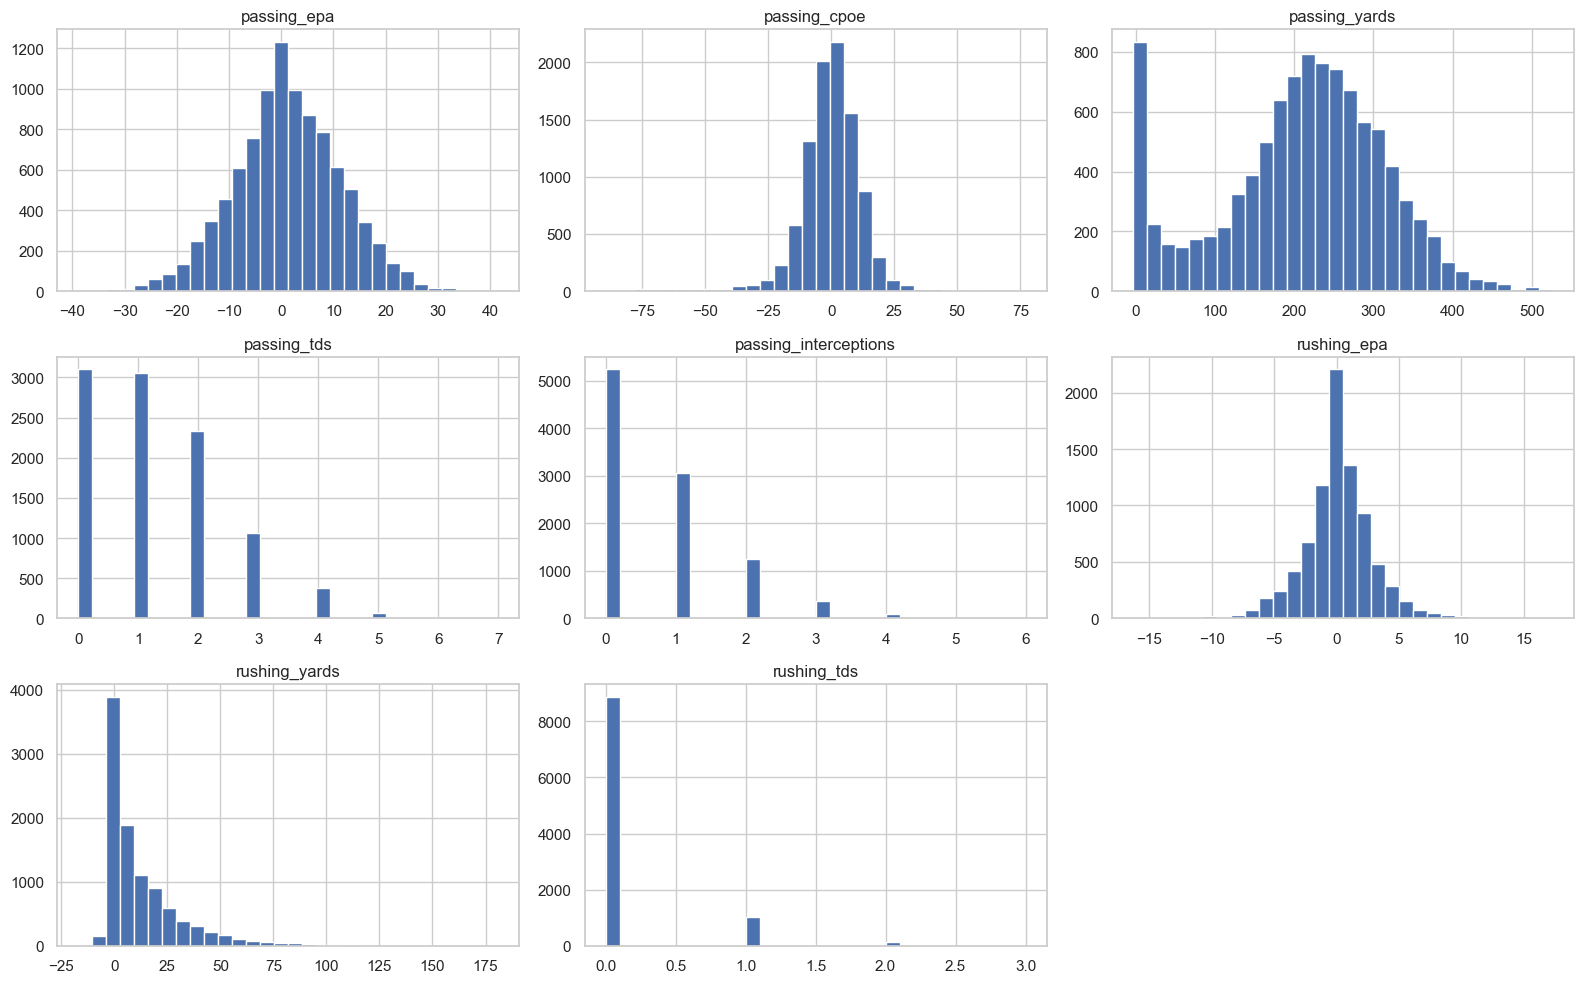

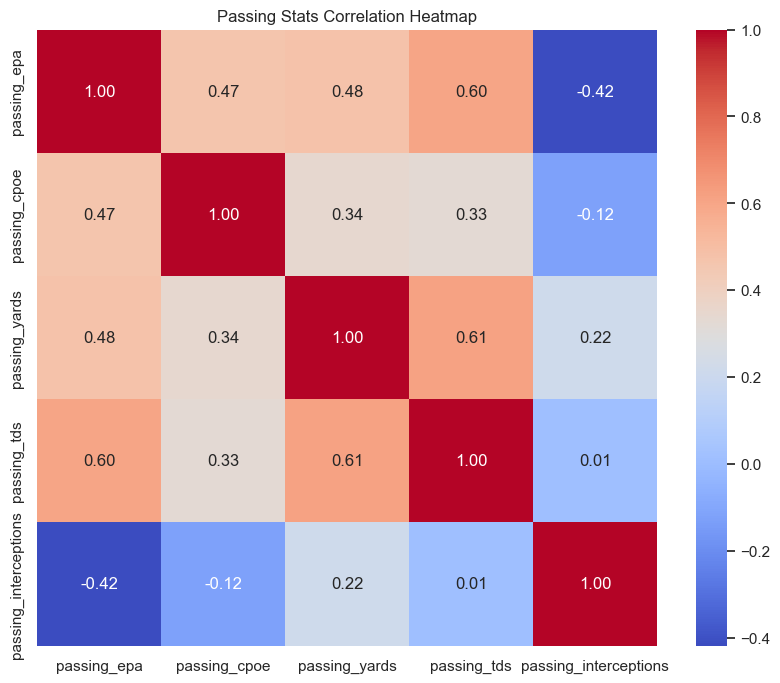

In [5]:
# Visualize distributions for key passing and rushing features
features = ['passing_epa', 'passing_cpoe', 'passing_yards', 'passing_tds', 
            'passing_interceptions', 'rushing_epa', 'rushing_yards', 'rushing_tds']

df[features].hist(bins=30, figsize=(16, 10), layout=(3, 3))
plt.tight_layout()
plt.show()

# Correlation heatmap for passing stats
passing_features = ['passing_epa', 'passing_cpoe', 'passing_yards', 'passing_tds', 'passing_interceptions']
plt.figure(figsize=(10, 8))
sns.heatmap(df[passing_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Passing Stats Correlation Heatmap')
plt.show()

## 6. Grouped Analysis (By Year, Team, Player)

Analyze trends and differences by season, team, or player. Visualize group means, distributions, and top performers.

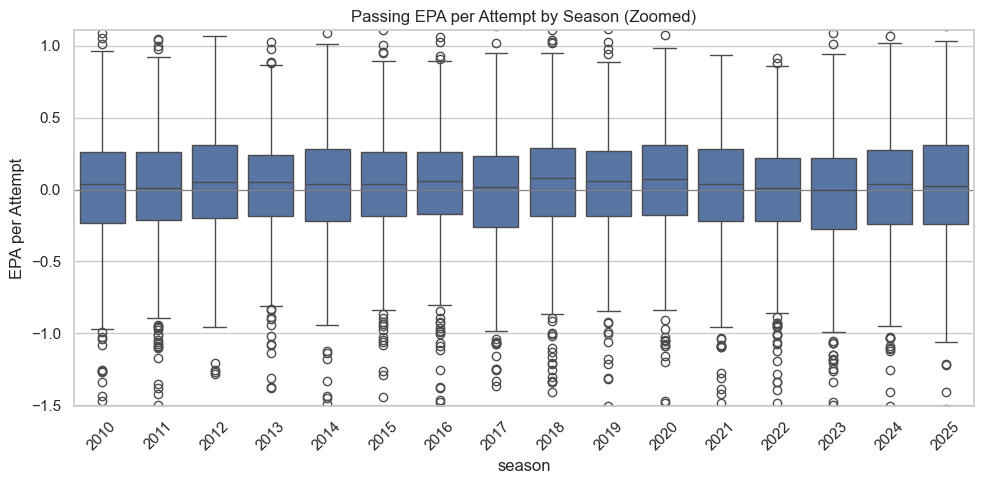

In [6]:
# Passing EPA by Season (per attempt, zoomed by clipping outliers)
# Compute EPA per attempt to normalize and get realistic scale
attempt_col = 'attempts' if 'attempts' in df.columns else ('passing_attempts' if 'passing_attempts' in df.columns else None)
if attempt_col is None:
    print('No attempts column found in dataframe')
else:
    df_norm = df.copy()
    df_norm[attempt_col] = pd.to_numeric(df_norm[attempt_col], errors='coerce').fillna(0)
    # Avoid division by zero
    df_norm['epa_per_attempt'] = df_norm['passing_epa'] / df_norm[attempt_col].replace(0, np.nan)

    # Compute zoom bounds using percentiles (clip extreme outliers)
    p_low, p_high = df_norm['epa_per_attempt'].quantile([0.01, 0.99])

    plt.figure(figsize=(10, 5))
    sns.boxplot(x='season', y='epa_per_attempt', data=df_norm)
    plt.title('Passing EPA per Attempt by Season (Zoomed)')
    plt.ylabel('EPA per Attempt')
    plt.xticks(rotation=45)
    plt.axhline(0, color='gray', linewidth=0.8)
    # Set y-limits to zoom in and reduce impact of extreme outliers
    plt.ylim(p_low, p_high)
    plt.tight_layout()
    plt.show()

## 7. Missing Data & Outlier Analysis

Identify and visualize missing data and outliers. Consider imputation or removal strategies.

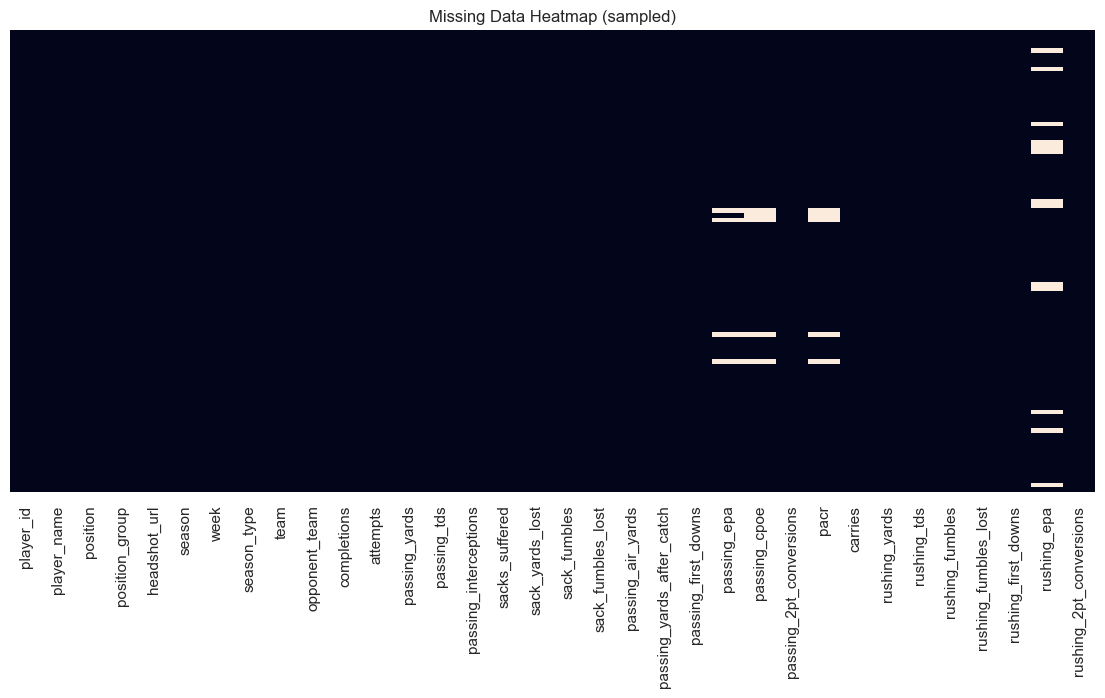

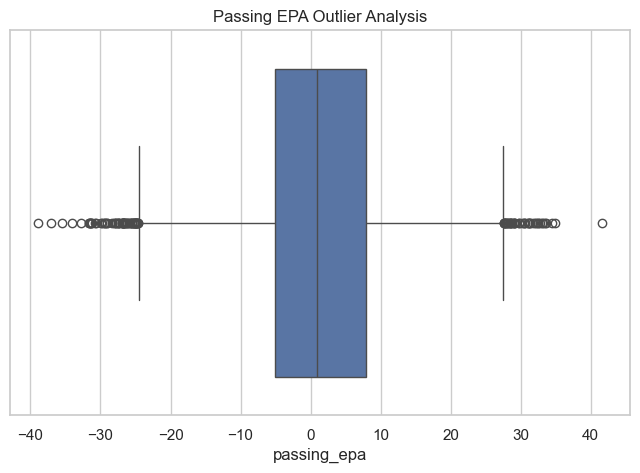

In [7]:
# Visualize missing data (sample every 100th row for readability)
plt.figure(figsize=(14, 6))
sns.heatmap(df.iloc[::100].isnull(), cbar=False, yticklabels=False)
plt.title('Missing Data Heatmap (sampled)')
plt.show()

# Outlier detection for passing EPA
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['passing_epa'])
plt.title('Passing EPA Outlier Analysis')
plt.show()

## 8. Feature Engineering Ideas

Brainstorm and prototype new features (e.g., rolling averages, rate stats, situational splits) for modeling.

In [8]:
# Create total EPA (passing + rushing)
df['total_epa'] = df['passing_epa'].fillna(0) + df['rushing_epa'].fillna(0)

# Create a TD/INT ratio feature (add small epsilon to avoid div by zero)
df['td_int_ratio'] = df['passing_tds'] / (df['passing_interceptions'] + 1e-6)

# Create completion percentage (safe division)
df['completion_pct'] = np.where(df['attempts'] > 0, df['completions'] / df['attempts'], np.nan)

# Create yards per attempt (safe division)
df['yards_per_attempt'] = np.where(df['attempts'] > 0, df['passing_yards'] / df['attempts'], np.nan)

# Calculate total dropbacks (attempts + sacks)
df['dropbacks'] = df['attempts'].fillna(0) + df['sacks_suffered'].fillna(0)

# Replace zero dropbacks with NaN for rate calculations to avoid inf
safe_dropbacks = df['dropbacks'].replace(0, np.nan)

# Turnover components (fill NaN with 0 for counts)
sack_fumbles = df['sack_fumbles_lost'].fillna(0)
rush_fumbles = df['rushing_fumbles_lost'].fillna(0)
ints = df['passing_interceptions'].fillna(0)

# Turnover percentage (fumbles lost + interceptions per dropback)
df['turnover_pct'] = ((sack_fumbles + rush_fumbles + ints) / safe_dropbacks) * 100

# Negative play percentage (sacks + fumbles lost + interceptions per dropback)
df['negative_play_pct'] = ((df['sacks_suffered'].fillna(0) + sack_fumbles + rush_fumbles + ints) / safe_dropbacks) * 100

# Optionally fill remaining NaNs in rate stats with 0 (comment out if you prefer NaNs)
for col in ['completion_pct', 'yards_per_attempt', 'turnover_pct', 'negative_play_pct']:
    df[col] = df[col].fillna(0)

print('New features created (NaN-safe):')
print('- total_epa, td_int_ratio, completion_pct, yards_per_attempt')
print('- turnover_pct (fumbles lost + INTs per dropback)')
print('- negative_play_pct (sacks + fumbles lost + INTs per dropback)')

print('\nTurnover % stats (after cleaning):')
print(df['turnover_pct'].describe())
print('\nNegative play % stats (after cleaning):')
print(df['negative_play_pct'].describe())

New features created (NaN-safe):
- total_epa, td_int_ratio, completion_pct, yards_per_attempt
- turnover_pct (fumbles lost + INTs per dropback)
- negative_play_pct (sacks + fumbles lost + INTs per dropback)

Turnover % stats (after cleaning):
count    10029.000000
mean         2.968187
std          5.543285
min          0.000000
25%          0.000000
50%          2.272727
75%          4.347826
max        100.000000
Name: turnover_pct, dtype: float64

Negative play % stats (after cleaning):
count    10029.000000
mean         9.448995
std          9.818151
min          0.000000
25%          3.703704
50%          8.108108
75%         12.500000
max        200.000000
Name: negative_play_pct, dtype: float64


In [10]:
# Persist engineered features to SQLite as an enriched table
# This creates/overwrites qb_statistics_enriched with all current columns + new features.
import sqlite3

with sqlite3.connect(db_path) as _conn:
    df.to_sql('qb_statistics_enriched', _conn, if_exists='replace', index=False)

print('Saved enriched QB dataset to table: qb_statistics_enriched')
print(f'Columns saved: {len(df.columns)}')

Saved enriched QB dataset to table: qb_statistics_enriched
Columns saved: 41


In [11]:
# OPTIONAL: Migrate engineered features into original qb_statistics table
# This adds missing columns and populates them directly via SQL calculations.
# Safe to run multiple times; existing columns are skipped.
import sqlite3
import pandas as pd

feature_defs = {
    'total_epa': 'REAL',
    'td_int_ratio': 'REAL',
    'completion_pct': 'REAL',
    'yards_per_attempt': 'REAL',
    'dropbacks': 'INTEGER',
    'turnover_pct': 'REAL',
    'negative_play_pct': 'REAL'
}

with sqlite3.connect(db_path) as mconn:
    existing_cols = set(pd.read_sql("PRAGMA table_info(qb_statistics);", mconn)['name'])

    # Add columns if they do not exist
    for col, col_type in feature_defs.items():
        if col not in existing_cols:
            mconn.execute(f"ALTER TABLE qb_statistics ADD COLUMN {col} {col_type}")

    # Populate calculable columns (first batch)
    mconn.execute("""
    UPDATE qb_statistics
    SET total_epa = COALESCE(passing_epa,0) + COALESCE(rushing_epa,0),
        td_int_ratio = CASE 
            WHEN passing_interceptions IS NOT NULL 
            THEN CAST(passing_tds AS REAL) / (passing_interceptions + 1e-6)
            ELSE NULL END,
        completion_pct = CASE WHEN attempts > 0 THEN CAST(completions AS REAL)/attempts ELSE 0 END,
        yards_per_attempt = CASE WHEN attempts > 0 THEN CAST(passing_yards AS REAL)/attempts ELSE 0 END,
        dropbacks = COALESCE(attempts,0) + COALESCE(sacks_suffered,0)
    """)

    # Populate turnover-based percentages (second batch, needs dropbacks value)
    mconn.execute("""
    UPDATE qb_statistics
    SET turnover_pct = CASE WHEN dropbacks > 0 THEN 100.0 * (
            COALESCE(sack_fumbles_lost,0) + COALESCE(rushing_fumbles_lost,0) + COALESCE(passing_interceptions,0)
        ) / dropbacks ELSE 0 END,
        negative_play_pct = CASE WHEN dropbacks > 0 THEN 100.0 * (
            COALESCE(sacks_suffered,0) + COALESCE(sack_fumbles_lost,0) + COALESCE(rushing_fumbles_lost,0) + COALESCE(passing_interceptions,0)
        ) / dropbacks ELSE 0 END
    """)

    # Optional indexing for performance
    mconn.execute("CREATE INDEX IF NOT EXISTS idx_qb_stats_player ON qb_statistics(player_name)")
    mconn.execute("CREATE INDEX IF NOT EXISTS idx_qb_stats_season ON qb_statistics(season)")

print("qb_statistics table updated with engineered feature columns (if they were missing).")

qb_statistics table updated with engineered feature columns (if they were missing).
